In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from math import radians, cos, sin, asin, sqrt
%matplotlib inline
import matplotlib.pyplot as plt
from knn_regression import KNN 
from nwk import NWK
from sklearn.cross_validation import train_test_split

### Load data

In [3]:
df0 = pd.read_csv("data.csv")

In [4]:
df0.columns

Index([u'latitude', u'longitude', u'close_date', u'close_price'], dtype='object')

In [5]:
df0.describe()

,latitude,longitude,close_price
count,88042.000000,88042.000000,8.804200e+04
mean,34.559745,-93.470194,2.663684e+06
std,13.983900,31.194818,1.543381e+07
min,-89.938989,-179.891580,-9.995300e+04
25%,36.200312,-98.481499,1.233064e+05
50%,36.385215,-98.165490,1.816143e+05
75%,36.544719,-97.967260,2.841568e+05
max,89.984841,179.969440,1.009998e+08


Note that there are negative values in the column "close_price". To correct this error, we convert all values in the column to its absolute values.

In [6]:
df0.close_price = df0.close_price.apply(lambda x: abs(x))

Let's explore whether there're any unique patterns of hour location.

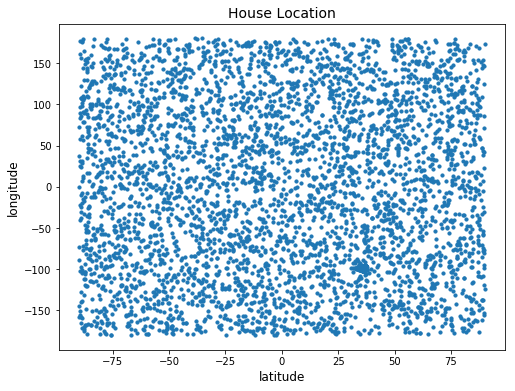

In [72]:
fig, ax = plt.subplots()
df0[['latitude','longitude']].plot(ax=ax, kind='scatter', x='latitude', y='longitude', s = 10,figsize=(8,6))
plt.xlabel('latitude', fontsize=12)
plt.ylabel('longitude', fontsize=12)
plt.title('House Location', fontsize=14)

### Model training

We used all the data points as training data and sampled 100 data points for the test data.

In [7]:
# create design matrix X and target vector y
X_train = np.array(df0.ix[:, 0:3]) 
y_train = np.array(df0['close_price']) 
df = df0.sample(100)
X_test = np.array(df.ix[:, 0:3]) 
y_test = np.array(df['close_price']) 

### Performance of model measured in Median Relative Absolute Error (MRAE)

In [45]:
knn = KNN(4)
t0 = datetime.now()
knn.fit(X_train, y_train)
# p = knn.predict(X_test)
print knn.mrae(X_test,y_test)
print ("Training time:", (datetime.now() - t0))

2 Nan values have been predicted
0.234868156186
('Training time:', datetime.timedelta(0, 62, 477000))


It takes more than one minute to train all the data. We achieved a low MRAE of this knn model.

### Determine the optimal k

We used cross-validation to choose the optimal k. The optimal k is found by minimizing the MRAE. We finally achieved a MRAE as low as 0.35.

In [8]:
data = df0.sample(1000)
X = np.array(data.ix[:, 0:3]) 
y = np.array(data['close_price']) 
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
k_list = []
mrae_list = []
for k in (1,2,3,4,5,6,7):
    knn = KNN(k)
    knn.fit(X_train, y_train)
    p = knn.predict(X_test)
    k_list.append(k)
    mrae_list.append(knn.mrae(X_test,y_test))

In [15]:
knn = KNN(k_list[mrae_list.index(min(mrae_list))])
t0 = datetime.now()
knn.fit(X_train, y_train)
print knn.mrae(X_test,y_test)
print ("Training time:", (datetime.now() - t0))

0.373203668688
('Training time:', datetime.timedelta(0, 1, 245000))


### Trends in error

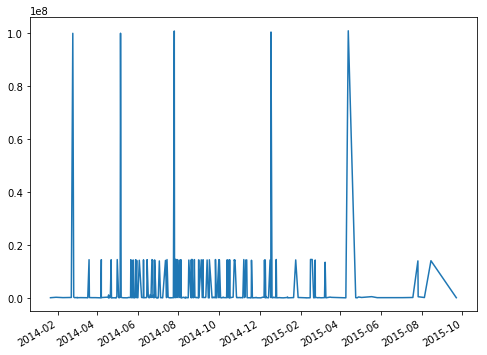

In [21]:
err = abs(y_test - p)
X_test_df = pd.DataFrame(X_test)
X_test_df.columns = ['lat','long','datetime']
X_test_df['error'] = err
X_test_df['datetime'] = X_test_df.datetime.apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f'))
X_test_df = X_test_df.sort_values(by = 'datetime')

fig, ax = plt.subplots(1,figsize=(8,6))
ax.plot(X_test_df.datetime, X_test_df.error )
fig.autofmt_xdate()

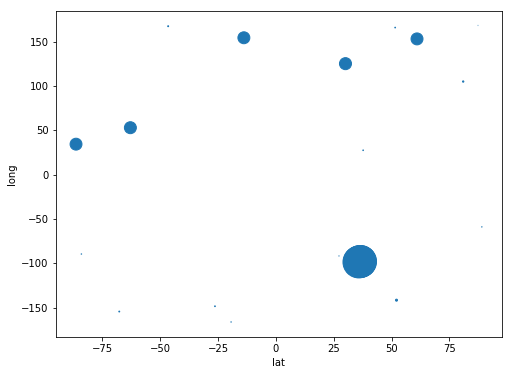

In [22]:
# size = [(i-min(X_test_df.error))/float(max(X_test_df.error)) for i in X_test_df.error]
fig, ax = plt.subplots()
X_test_df.plot(ax=ax, kind='scatter', x='lat', y='long', s = X_test_df.error/100000 ,figsize=(8,6))
# plt.xlabel('Rating', fontsize=12)
# plt.ylabel('Length', fontsize=12)
# plt.title('Movie Rating vs. Length', fontsize=14)

In [23]:
X_test_df[X_test_df.error > 90000000]

,lat,long,datetime,error
33,36.6133,-98.0545,2014-02-23 20:00:35.855886,9.980581e+07
148,36.558,-97.9942,2014-05-06 08:59:53.896686,9.983487e+07
274,36.1382,-98.2087,2014-07-25 23:07:46.071360,1.006795e+08
66,35.8333,-98.6898,2014-12-17 22:23:28.147380,1.003009e+08
271,36.4146,-97.9964,2015-04-12 18:40:20.897554,1.007556e+08


Interestingly, the spatial location of houses with highest prediction error scatter around (36,-97), which is around Oklahoma. 

In [25]:
X_test_df[(X_test_df.error > 14000000) &(X_test_df.error < 20000000)]

,lat,long,datetime,error
208,36.6417,-98.3541,2014-03-20 04:54:12.774417,1.439877e+07
80,36.7188,-98.2095,2014-04-07 14:13:39.497958,1.440447e+07
27,36.0661,-98.6063,2014-04-22 07:34:01.314041,1.436781e+07
64,36.6678,-98.385,2014-05-01 10:40:32.073724,1.444960e+07
216,36.1189,-98.6628,2014-05-21 19:44:49.150917,1.437929e+07
193,36.6567,-98.0576,2014-05-25 05:45:00.658251,1.427507e+07
130,36.5915,-98.1386,2014-05-25 09:55:35.151603,1.429014e+07
111,36.1567,-98.607,2014-05-29 01:26:31.069883,1.437435e+07
165,36.6848,-98.145,2014-05-30 14:12:26.171543,1.414119e+07
215,36.682,-98.1625,2014-06-03 12:24:38.242906,1.419539e+07


A number of high predictive error occurs at locations around (36,-98) at different times. Both highest prediction errors and relative high prediction erros scatter around north Oklahoma.

### Improvement in model

We could also give each house price in the data set a weight depending on whether it is in the neighbourd rather than taking the average to get the price. Here, the Nadaraya–Watson kernel regression model serves as a comparision to the knn model, whereas the Kernal method puts weights on all prices in the data set according to the kernel function. Similarly, the optimal bandwidth is found by minimizing the estimated cross-validation risk as in the function. We finally achieved a MRAE as low as 0.35, which is lower than the one using knn model (0.373203668688). However, this model generates more nan values and takes longer time than the knn model.

In [9]:
print len(X_test)
nwk = NWK(0.01)
t0 = datetime.now()
nwk.fit(X_train, y_train)
print nwk.mrae(X_test,y_test)
print ("Training time:", (datetime.now() - t0))

330


nwk.py:72: RuntimeWarning: invalid value encountered in double_scalars
  sum_y += kernel[ll] / float(sum(kernel)) * self.y_train[distances[ll][1]]


16 Nan values have been predicted
0.440484366185
('Training time:', datetime.timedelta(0, 16, 314000))


In [16]:
# determine the optimal h
h_list = []
mrae_list = []
for h in np.linspace(start=0.001, stop=0.01, num=10):
    nwk = NWK(h)
    nwk.fit(X_train, y_train)
    h_list.append(h)
    mrae_list.append(nwk.mrae(X_test,y_test))

105 Nan values have been predicted
54 Nan values have been predicted
40 Nan values have been predicted
32 Nan values have been predicted
26 Nan values have been predicted
23 Nan values have been predicted
20 Nan values have been predicted
20 Nan values have been predicted
17 Nan values have been predicted
16 Nan values have been predicted


In [17]:
mrae_list

[0.3577765965349689,
 0.40399594690480511,
 0.40262722906282894,
 0.40602218506071608,
 0.41034195347299296,
 0.41467334655623794,
 0.42734445218449146,
 0.43301928276456014,
 0.43118444590661087,
 0.44048436618510578]

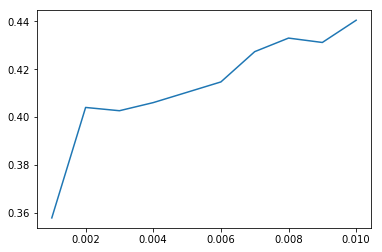

In [18]:
plt.plot(h_list, mrae_list)

In [19]:
print len(X_test)
nwk = NWK(h_list[mrae_list.index(min(mrae_list))])
t0 = datetime.now()
nwk.fit(X_train, y_train)
print nwk.mrae(X_test,y_test)
print ("Training time:", (datetime.now() - t0))

330
105 Nan values have been predicted
0.357776596535
('Training time:', datetime.timedelta(0, 15, 974000))


### Productionize in model

In order to production both models, we added instructions and documentations to our model.
* adding documentation to Python code to clearly state the functions of each part of the model
* adding test cases in the model, such as empty input, erroruous format of input data, etc.
* inform the users how many nan values were generated.

In [8]:
knn_test1 = KNN(-1)

SystemExit: K must be a positive integer

In [10]:
knn_test1 = KNN(4)
knn_test1.fit([], y_train)

SystemExit: Training data cannot be empty

In [12]:
knn_test1 = KNN(4)
knn_test1.fit(X_train, y_train)
knn_test1.mrae(X_test,y_test)

SystemExit: House should not have negative price

In [8]:
y_train = abs(y_train)
knn_test1 = KNN(4)
knn_test1.fit(X_train, y_train)
knn_test1.mrae([],y_test)

SystemExit: Test data cannot be empty

In [9]:
knn_test1 = KNN(4)
knn_test1.fit(X_train, y_train)
knn_test1.mrae(X_test,y_test)

1 Nan values have been predicted


0.37336928902032457